# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [6]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [8]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 128)          1152        ['input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 128)          16512       ['dense_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 64)           8256        ['dense_4[0][0]']                
                                                                                            

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [9]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

/home/pablo/anaconda3/envs/tf-gpu-207/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Train the Model

In [10]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 3s 11ms/step - loss: 265.5280 - y1_output_loss: 125.6443 - y2_output_loss: 139.8837 - y1_output_root_mean_squared_error: 11.2091 - y2_output_root_mean_squared_error: 11.8272 - val_loss: 32.8205 - val_y1_output_loss: 13.9007 - val_y2_output_loss: 18.9198 - val_y1_output_root_mean_squared_error: 3.7284 - val_y2_output_root_mean_squared_error: 4.3497
Epoch 2/500
62/62 [==============================] - 1s 9ms/step - loss: 31.5896 - y1_output_loss: 12.1335 - y2_output_loss: 19.4561 - y1_output_root_mean_squared_error: 3.4833 - y2_output_root_mean_squared_error: 4.4109 - val_loss: 24.9583 - val_y1_output_loss: 12.0534 - val_y2_output_loss: 12.9050 - val_y1_output_root_mean_squared_error: 3.4718 - val_y2_output_root_mean_squared_error: 3.5923
Epoch 3/500
62/62 [==============================] - 1s 9ms/step - loss: 27.1753 - y1_output_loss: 10.1606 - y2_output_loss: 17.0146 - y1_output_root_mean_squared_error: 3.1876 - y2_output_root_mean_s

Epoch 22/500
62/62 [==============================] - 1s 8ms/step - loss: 13.0485 - y1_output_loss: 4.9706 - y2_output_loss: 8.0779 - y1_output_root_mean_squared_error: 2.2295 - y2_output_root_mean_squared_error: 2.8422 - val_loss: 72.8254 - val_y1_output_loss: 18.3016 - val_y2_output_loss: 54.5238 - val_y1_output_root_mean_squared_error: 4.2780 - val_y2_output_root_mean_squared_error: 7.3840
Epoch 23/500
62/62 [==============================] - 1s 9ms/step - loss: 18.1416 - y1_output_loss: 6.0340 - y2_output_loss: 12.1076 - y1_output_root_mean_squared_error: 2.4564 - y2_output_root_mean_squared_error: 3.4796 - val_loss: 16.2172 - val_y1_output_loss: 6.8280 - val_y2_output_loss: 9.3893 - val_y1_output_root_mean_squared_error: 2.6130 - val_y2_output_root_mean_squared_error: 3.0642
Epoch 24/500
62/62 [==============================] - 1s 10ms/step - loss: 14.3174 - y1_output_loss: 5.1794 - y2_output_loss: 9.1381 - y1_output_root_mean_squared_error: 2.2758 - y2_output_root_mean_squared_er

Epoch 43/500
62/62 [==============================] - 1s 9ms/step - loss: 6.6008 - y1_output_loss: 2.2738 - y2_output_loss: 4.3270 - y1_output_root_mean_squared_error: 1.5079 - y2_output_root_mean_squared_error: 2.0802 - val_loss: 9.0126 - val_y1_output_loss: 2.5367 - val_y2_output_loss: 6.4758 - val_y1_output_root_mean_squared_error: 1.5927 - val_y2_output_root_mean_squared_error: 2.5448
Epoch 44/500
62/62 [==============================] - 1s 9ms/step - loss: 7.3437 - y1_output_loss: 2.5371 - y2_output_loss: 4.8066 - y1_output_root_mean_squared_error: 1.5928 - y2_output_root_mean_squared_error: 2.1924 - val_loss: 7.2893 - val_y1_output_loss: 2.4619 - val_y2_output_loss: 4.8274 - val_y1_output_root_mean_squared_error: 1.5691 - val_y2_output_root_mean_squared_error: 2.1971
Epoch 45/500
62/62 [==============================] - 1s 9ms/step - loss: 7.3335 - y1_output_loss: 2.4451 - y2_output_loss: 4.8884 - y1_output_root_mean_squared_error: 1.5637 - y2_output_root_mean_squared_error: 2.21

Epoch 64/500
62/62 [==============================] - 1s 8ms/step - loss: 5.9592 - y1_output_loss: 1.8469 - y2_output_loss: 4.1123 - y1_output_root_mean_squared_error: 1.3590 - y2_output_root_mean_squared_error: 2.0279 - val_loss: 11.2579 - val_y1_output_loss: 3.1892 - val_y2_output_loss: 8.0687 - val_y1_output_root_mean_squared_error: 1.7858 - val_y2_output_root_mean_squared_error: 2.8405
Epoch 65/500
62/62 [==============================] - 1s 9ms/step - loss: 5.1734 - y1_output_loss: 1.4703 - y2_output_loss: 3.7031 - y1_output_root_mean_squared_error: 1.2126 - y2_output_root_mean_squared_error: 1.9243 - val_loss: 29.8186 - val_y1_output_loss: 5.7601 - val_y2_output_loss: 24.0586 - val_y1_output_root_mean_squared_error: 2.4000 - val_y2_output_root_mean_squared_error: 4.9050
Epoch 66/500
62/62 [==============================] - 1s 9ms/step - loss: 6.2815 - y1_output_loss: 1.8354 - y2_output_loss: 4.4461 - y1_output_root_mean_squared_error: 1.3548 - y2_output_root_mean_squared_error: 2

Epoch 85/500
62/62 [==============================] - 1s 8ms/step - loss: 3.4553 - y1_output_loss: 0.7996 - y2_output_loss: 2.6557 - y1_output_root_mean_squared_error: 0.8942 - y2_output_root_mean_squared_error: 1.6296 - val_loss: 10.5161 - val_y1_output_loss: 1.9758 - val_y2_output_loss: 8.5403 - val_y1_output_root_mean_squared_error: 1.4056 - val_y2_output_root_mean_squared_error: 2.9224
Epoch 86/500
62/62 [==============================] - 1s 8ms/step - loss: 11.5172 - y1_output_loss: 3.3262 - y2_output_loss: 8.1909 - y1_output_root_mean_squared_error: 1.8238 - y2_output_root_mean_squared_error: 2.8620 - val_loss: 4.1421 - val_y1_output_loss: 1.1481 - val_y2_output_loss: 2.9940 - val_y1_output_root_mean_squared_error: 1.0715 - val_y2_output_root_mean_squared_error: 1.7303
Epoch 87/500
62/62 [==============================] - 1s 8ms/step - loss: 3.3992 - y1_output_loss: 0.8362 - y2_output_loss: 2.5630 - y1_output_root_mean_squared_error: 0.9145 - y2_output_root_mean_squared_error: 1.

Epoch 106/500
62/62 [==============================] - 1s 9ms/step - loss: 3.1845 - y1_output_loss: 0.6524 - y2_output_loss: 2.5321 - y1_output_root_mean_squared_error: 0.8077 - y2_output_root_mean_squared_error: 1.5912 - val_loss: 4.3643 - val_y1_output_loss: 0.9035 - val_y2_output_loss: 3.4607 - val_y1_output_root_mean_squared_error: 0.9505 - val_y2_output_root_mean_squared_error: 1.8603
Epoch 107/500
62/62 [==============================] - 1s 9ms/step - loss: 3.1212 - y1_output_loss: 0.7564 - y2_output_loss: 2.3648 - y1_output_root_mean_squared_error: 0.8697 - y2_output_root_mean_squared_error: 1.5378 - val_loss: 3.4641 - val_y1_output_loss: 0.7169 - val_y2_output_loss: 2.7472 - val_y1_output_root_mean_squared_error: 0.8467 - val_y2_output_root_mean_squared_error: 1.6575
Epoch 108/500
62/62 [==============================] - 1s 9ms/step - loss: 3.5585 - y1_output_loss: 0.7692 - y2_output_loss: 2.7894 - y1_output_root_mean_squared_error: 0.8770 - y2_output_root_mean_squared_error: 1

Epoch 127/500
62/62 [==============================] - 1s 8ms/step - loss: 2.8762 - y1_output_loss: 0.6472 - y2_output_loss: 2.2290 - y1_output_root_mean_squared_error: 0.8045 - y2_output_root_mean_squared_error: 1.4930 - val_loss: 2.2650 - val_y1_output_loss: 0.4708 - val_y2_output_loss: 1.7941 - val_y1_output_root_mean_squared_error: 0.6862 - val_y2_output_root_mean_squared_error: 1.3395
Epoch 128/500
62/62 [==============================] - 1s 8ms/step - loss: 4.4514 - y1_output_loss: 1.0938 - y2_output_loss: 3.3576 - y1_output_root_mean_squared_error: 1.0459 - y2_output_root_mean_squared_error: 1.8324 - val_loss: 2.5533 - val_y1_output_loss: 0.4069 - val_y2_output_loss: 2.1464 - val_y1_output_root_mean_squared_error: 0.6379 - val_y2_output_root_mean_squared_error: 1.4651
Epoch 129/500
62/62 [==============================] - 1s 8ms/step - loss: 5.8609 - y1_output_loss: 1.6127 - y2_output_loss: 4.2481 - y1_output_root_mean_squared_error: 1.2699 - y2_output_root_mean_squared_error: 2

Epoch 148/500
62/62 [==============================] - 1s 9ms/step - loss: 3.0434 - y1_output_loss: 0.6124 - y2_output_loss: 2.4310 - y1_output_root_mean_squared_error: 0.7826 - y2_output_root_mean_squared_error: 1.5592 - val_loss: 6.1040 - val_y1_output_loss: 0.7379 - val_y2_output_loss: 5.3661 - val_y1_output_root_mean_squared_error: 0.8590 - val_y2_output_root_mean_squared_error: 2.3165
Epoch 149/500
62/62 [==============================] - 0s 8ms/step - loss: 2.2517 - y1_output_loss: 0.4369 - y2_output_loss: 1.8148 - y1_output_root_mean_squared_error: 0.6610 - y2_output_root_mean_squared_error: 1.3471 - val_loss: 2.6202 - val_y1_output_loss: 0.5877 - val_y2_output_loss: 2.0325 - val_y1_output_root_mean_squared_error: 0.7666 - val_y2_output_root_mean_squared_error: 1.4257
Epoch 150/500
62/62 [==============================] - 1s 8ms/step - loss: 1.7305 - y1_output_loss: 0.3529 - y2_output_loss: 1.3776 - y1_output_root_mean_squared_error: 0.5940 - y2_output_root_mean_squared_error: 1

Epoch 169/500
62/62 [==============================] - 1s 8ms/step - loss: 2.1660 - y1_output_loss: 0.4562 - y2_output_loss: 1.7098 - y1_output_root_mean_squared_error: 0.6754 - y2_output_root_mean_squared_error: 1.3076 - val_loss: 1.7776 - val_y1_output_loss: 0.2860 - val_y2_output_loss: 1.4916 - val_y1_output_root_mean_squared_error: 0.5348 - val_y2_output_root_mean_squared_error: 1.2213
Epoch 170/500
62/62 [==============================] - 1s 9ms/step - loss: 1.5954 - y1_output_loss: 0.3316 - y2_output_loss: 1.2638 - y1_output_root_mean_squared_error: 0.5758 - y2_output_root_mean_squared_error: 1.1242 - val_loss: 1.8156 - val_y1_output_loss: 0.3193 - val_y2_output_loss: 1.4963 - val_y1_output_root_mean_squared_error: 0.5651 - val_y2_output_root_mean_squared_error: 1.2232
Epoch 171/500
62/62 [==============================] - 1s 8ms/step - loss: 3.3466 - y1_output_loss: 0.6730 - y2_output_loss: 2.6737 - y1_output_root_mean_squared_error: 0.8204 - y2_output_root_mean_squared_error: 1

Epoch 190/500
62/62 [==============================] - 1s 8ms/step - loss: 1.6167 - y1_output_loss: 0.3189 - y2_output_loss: 1.2978 - y1_output_root_mean_squared_error: 0.5647 - y2_output_root_mean_squared_error: 1.1392 - val_loss: 1.7535 - val_y1_output_loss: 0.3317 - val_y2_output_loss: 1.4217 - val_y1_output_root_mean_squared_error: 0.5760 - val_y2_output_root_mean_squared_error: 1.1924
Epoch 191/500
62/62 [==============================] - 1s 8ms/step - loss: 1.4812 - y1_output_loss: 0.2778 - y2_output_loss: 1.2034 - y1_output_root_mean_squared_error: 0.5271 - y2_output_root_mean_squared_error: 1.0970 - val_loss: 3.1409 - val_y1_output_loss: 0.4949 - val_y2_output_loss: 2.6461 - val_y1_output_root_mean_squared_error: 0.7035 - val_y2_output_root_mean_squared_error: 1.6267
Epoch 192/500
62/62 [==============================] - 1s 8ms/step - loss: 1.6355 - y1_output_loss: 0.2987 - y2_output_loss: 1.3368 - y1_output_root_mean_squared_error: 0.5465 - y2_output_root_mean_squared_error: 1

Epoch 211/500
62/62 [==============================] - 1s 8ms/step - loss: 1.4836 - y1_output_loss: 0.2779 - y2_output_loss: 1.2057 - y1_output_root_mean_squared_error: 0.5272 - y2_output_root_mean_squared_error: 1.0980 - val_loss: 2.5942 - val_y1_output_loss: 0.3795 - val_y2_output_loss: 2.2147 - val_y1_output_root_mean_squared_error: 0.6160 - val_y2_output_root_mean_squared_error: 1.4882
Epoch 212/500
62/62 [==============================] - 1s 8ms/step - loss: 1.1742 - y1_output_loss: 0.2510 - y2_output_loss: 0.9233 - y1_output_root_mean_squared_error: 0.5010 - y2_output_root_mean_squared_error: 0.9609 - val_loss: 2.5093 - val_y1_output_loss: 0.4312 - val_y2_output_loss: 2.0782 - val_y1_output_root_mean_squared_error: 0.6566 - val_y2_output_root_mean_squared_error: 1.4416
Epoch 213/500
62/62 [==============================] - 1s 9ms/step - loss: 1.2530 - y1_output_loss: 0.2183 - y2_output_loss: 1.0347 - y1_output_root_mean_squared_error: 0.4672 - y2_output_root_mean_squared_error: 1

Epoch 232/500
62/62 [==============================] - 1s 8ms/step - loss: 1.2128 - y1_output_loss: 0.2260 - y2_output_loss: 0.9868 - y1_output_root_mean_squared_error: 0.4754 - y2_output_root_mean_squared_error: 0.9934 - val_loss: 1.3945 - val_y1_output_loss: 0.2359 - val_y2_output_loss: 1.1586 - val_y1_output_root_mean_squared_error: 0.4856 - val_y2_output_root_mean_squared_error: 1.0764
Epoch 233/500
62/62 [==============================] - 1s 10ms/step - loss: 1.1611 - y1_output_loss: 0.2192 - y2_output_loss: 0.9418 - y1_output_root_mean_squared_error: 0.4682 - y2_output_root_mean_squared_error: 0.9705 - val_loss: 4.5645 - val_y1_output_loss: 1.1685 - val_y2_output_loss: 3.3960 - val_y1_output_root_mean_squared_error: 1.0810 - val_y2_output_root_mean_squared_error: 1.8428
Epoch 234/500
62/62 [==============================] - 1s 9ms/step - loss: 1.0429 - y1_output_loss: 0.2151 - y2_output_loss: 0.8278 - y1_output_root_mean_squared_error: 0.4638 - y2_output_root_mean_squared_error: 

Epoch 253/500
62/62 [==============================] - 1s 8ms/step - loss: 0.9745 - y1_output_loss: 0.2253 - y2_output_loss: 0.7492 - y1_output_root_mean_squared_error: 0.4746 - y2_output_root_mean_squared_error: 0.8656 - val_loss: 2.0481 - val_y1_output_loss: 0.2644 - val_y2_output_loss: 1.7837 - val_y1_output_root_mean_squared_error: 0.5142 - val_y2_output_root_mean_squared_error: 1.3356
Epoch 254/500
62/62 [==============================] - 1s 10ms/step - loss: 1.2732 - y1_output_loss: 0.2738 - y2_output_loss: 0.9994 - y1_output_root_mean_squared_error: 0.5233 - y2_output_root_mean_squared_error: 0.9997 - val_loss: 1.8861 - val_y1_output_loss: 0.5517 - val_y2_output_loss: 1.3344 - val_y1_output_root_mean_squared_error: 0.7428 - val_y2_output_root_mean_squared_error: 1.1552
Epoch 255/500
62/62 [==============================] - 1s 9ms/step - loss: 1.0297 - y1_output_loss: 0.2173 - y2_output_loss: 0.8124 - y1_output_root_mean_squared_error: 0.4662 - y2_output_root_mean_squared_error: 

Epoch 274/500
62/62 [==============================] - 1s 8ms/step - loss: 0.7735 - y1_output_loss: 0.1660 - y2_output_loss: 0.6075 - y1_output_root_mean_squared_error: 0.4075 - y2_output_root_mean_squared_error: 0.7794 - val_loss: 1.1790 - val_y1_output_loss: 0.2089 - val_y2_output_loss: 0.9701 - val_y1_output_root_mean_squared_error: 0.4570 - val_y2_output_root_mean_squared_error: 0.9850
Epoch 275/500
62/62 [==============================] - 1s 8ms/step - loss: 0.8769 - y1_output_loss: 0.1731 - y2_output_loss: 0.7037 - y1_output_root_mean_squared_error: 0.4161 - y2_output_root_mean_squared_error: 0.8389 - val_loss: 6.9800 - val_y1_output_loss: 2.1669 - val_y2_output_loss: 4.8131 - val_y1_output_root_mean_squared_error: 1.4720 - val_y2_output_root_mean_squared_error: 2.1939
Epoch 276/500
62/62 [==============================] - 1s 8ms/step - loss: 1.1575 - y1_output_loss: 0.2734 - y2_output_loss: 0.8841 - y1_output_root_mean_squared_error: 0.5228 - y2_output_root_mean_squared_error: 0

Epoch 295/500
62/62 [==============================] - 1s 9ms/step - loss: 0.7135 - y1_output_loss: 0.1715 - y2_output_loss: 0.5420 - y1_output_root_mean_squared_error: 0.4141 - y2_output_root_mean_squared_error: 0.7362 - val_loss: 1.1357 - val_y1_output_loss: 0.2333 - val_y2_output_loss: 0.9024 - val_y1_output_root_mean_squared_error: 0.4830 - val_y2_output_root_mean_squared_error: 0.9499
Epoch 296/500
62/62 [==============================] - 1s 9ms/step - loss: 0.7122 - y1_output_loss: 0.1747 - y2_output_loss: 0.5375 - y1_output_root_mean_squared_error: 0.4179 - y2_output_root_mean_squared_error: 0.7331 - val_loss: 1.3039 - val_y1_output_loss: 0.2421 - val_y2_output_loss: 1.0618 - val_y1_output_root_mean_squared_error: 0.4920 - val_y2_output_root_mean_squared_error: 1.0304
Epoch 297/500
62/62 [==============================] - 1s 8ms/step - loss: 0.7742 - y1_output_loss: 0.1677 - y2_output_loss: 0.6065 - y1_output_root_mean_squared_error: 0.4095 - y2_output_root_mean_squared_error: 0

Epoch 316/500
62/62 [==============================] - 1s 8ms/step - loss: 0.9443 - y1_output_loss: 0.2120 - y2_output_loss: 0.7323 - y1_output_root_mean_squared_error: 0.4605 - y2_output_root_mean_squared_error: 0.8557 - val_loss: 1.1352 - val_y1_output_loss: 0.2845 - val_y2_output_loss: 0.8507 - val_y1_output_root_mean_squared_error: 0.5334 - val_y2_output_root_mean_squared_error: 0.9223
Epoch 317/500
62/62 [==============================] - 1s 8ms/step - loss: 0.7806 - y1_output_loss: 0.1888 - y2_output_loss: 0.5918 - y1_output_root_mean_squared_error: 0.4345 - y2_output_root_mean_squared_error: 0.7693 - val_loss: 2.5008 - val_y1_output_loss: 0.2024 - val_y2_output_loss: 2.2984 - val_y1_output_root_mean_squared_error: 0.4499 - val_y2_output_root_mean_squared_error: 1.5160
Epoch 318/500
62/62 [==============================] - 1s 8ms/step - loss: 0.7256 - y1_output_loss: 0.1614 - y2_output_loss: 0.5642 - y1_output_root_mean_squared_error: 0.4017 - y2_output_root_mean_squared_error: 0

Epoch 337/500
62/62 [==============================] - 1s 8ms/step - loss: 0.8281 - y1_output_loss: 0.1989 - y2_output_loss: 0.6292 - y1_output_root_mean_squared_error: 0.4460 - y2_output_root_mean_squared_error: 0.7932 - val_loss: 2.1799 - val_y1_output_loss: 0.5103 - val_y2_output_loss: 1.6696 - val_y1_output_root_mean_squared_error: 0.7144 - val_y2_output_root_mean_squared_error: 1.2921
Epoch 338/500
62/62 [==============================] - 1s 9ms/step - loss: 0.5807 - y1_output_loss: 0.1645 - y2_output_loss: 0.4162 - y1_output_root_mean_squared_error: 0.4056 - y2_output_root_mean_squared_error: 0.6451 - val_loss: 1.0860 - val_y1_output_loss: 0.2097 - val_y2_output_loss: 0.8763 - val_y1_output_root_mean_squared_error: 0.4579 - val_y2_output_root_mean_squared_error: 0.9361
Epoch 339/500
62/62 [==============================] - 1s 9ms/step - loss: 0.7332 - y1_output_loss: 0.1732 - y2_output_loss: 0.5601 - y1_output_root_mean_squared_error: 0.4161 - y2_output_root_mean_squared_error: 0

Epoch 358/500
62/62 [==============================] - 1s 9ms/step - loss: 0.7956 - y1_output_loss: 0.1838 - y2_output_loss: 0.6118 - y1_output_root_mean_squared_error: 0.4287 - y2_output_root_mean_squared_error: 0.7822 - val_loss: 29.4373 - val_y1_output_loss: 6.2010 - val_y2_output_loss: 23.2363 - val_y1_output_root_mean_squared_error: 2.4902 - val_y2_output_root_mean_squared_error: 4.8204
Epoch 359/500
62/62 [==============================] - 1s 8ms/step - loss: 1.7340 - y1_output_loss: 0.4381 - y2_output_loss: 1.2959 - y1_output_root_mean_squared_error: 0.6619 - y2_output_root_mean_squared_error: 1.1384 - val_loss: 1.3117 - val_y1_output_loss: 0.2221 - val_y2_output_loss: 1.0896 - val_y1_output_root_mean_squared_error: 0.4713 - val_y2_output_root_mean_squared_error: 1.0438
Epoch 360/500
62/62 [==============================] - 1s 8ms/step - loss: 0.6800 - y1_output_loss: 0.1917 - y2_output_loss: 0.4883 - y1_output_root_mean_squared_error: 0.4378 - y2_output_root_mean_squared_error:

Epoch 379/500
62/62 [==============================] - 1s 8ms/step - loss: 0.6744 - y1_output_loss: 0.1819 - y2_output_loss: 0.4925 - y1_output_root_mean_squared_error: 0.4265 - y2_output_root_mean_squared_error: 0.7018 - val_loss: 0.8918 - val_y1_output_loss: 0.2148 - val_y2_output_loss: 0.6771 - val_y1_output_root_mean_squared_error: 0.4634 - val_y2_output_root_mean_squared_error: 0.8228
Epoch 380/500
62/62 [==============================] - 1s 8ms/step - loss: 0.5643 - y1_output_loss: 0.1502 - y2_output_loss: 0.4140 - y1_output_root_mean_squared_error: 0.3876 - y2_output_root_mean_squared_error: 0.6435 - val_loss: 0.9343 - val_y1_output_loss: 0.2135 - val_y2_output_loss: 0.7208 - val_y1_output_root_mean_squared_error: 0.4621 - val_y2_output_root_mean_squared_error: 0.8490
Epoch 381/500
62/62 [==============================] - 1s 9ms/step - loss: 0.5091 - y1_output_loss: 0.1389 - y2_output_loss: 0.3701 - y1_output_root_mean_squared_error: 0.3727 - y2_output_root_mean_squared_error: 0

Epoch 400/500
62/62 [==============================] - 1s 8ms/step - loss: 0.7064 - y1_output_loss: 0.2117 - y2_output_loss: 0.4947 - y1_output_root_mean_squared_error: 0.4601 - y2_output_root_mean_squared_error: 0.7033 - val_loss: 0.8812 - val_y1_output_loss: 0.2004 - val_y2_output_loss: 0.6808 - val_y1_output_root_mean_squared_error: 0.4476 - val_y2_output_root_mean_squared_error: 0.8251
Epoch 401/500
62/62 [==============================] - 1s 8ms/step - loss: 0.5403 - y1_output_loss: 0.1627 - y2_output_loss: 0.3775 - y1_output_root_mean_squared_error: 0.4034 - y2_output_root_mean_squared_error: 0.6144 - val_loss: 0.9587 - val_y1_output_loss: 0.3000 - val_y2_output_loss: 0.6587 - val_y1_output_root_mean_squared_error: 0.5477 - val_y2_output_root_mean_squared_error: 0.8116
Epoch 402/500
62/62 [==============================] - 1s 9ms/step - loss: 0.4740 - y1_output_loss: 0.1468 - y2_output_loss: 0.3272 - y1_output_root_mean_squared_error: 0.3831 - y2_output_root_mean_squared_error: 0

Epoch 421/500
62/62 [==============================] - 1s 9ms/step - loss: 0.4043 - y1_output_loss: 0.1311 - y2_output_loss: 0.2731 - y1_output_root_mean_squared_error: 0.3621 - y2_output_root_mean_squared_error: 0.5226 - val_loss: 1.0640 - val_y1_output_loss: 0.2245 - val_y2_output_loss: 0.8395 - val_y1_output_root_mean_squared_error: 0.4738 - val_y2_output_root_mean_squared_error: 0.9162
Epoch 422/500
62/62 [==============================] - 1s 9ms/step - loss: 0.3991 - y1_output_loss: 0.1347 - y2_output_loss: 0.2644 - y1_output_root_mean_squared_error: 0.3670 - y2_output_root_mean_squared_error: 0.5142 - val_loss: 0.7920 - val_y1_output_loss: 0.1987 - val_y2_output_loss: 0.5934 - val_y1_output_root_mean_squared_error: 0.4457 - val_y2_output_root_mean_squared_error: 0.7703
Epoch 423/500
62/62 [==============================] - 1s 8ms/step - loss: 0.6248 - y1_output_loss: 0.1816 - y2_output_loss: 0.4432 - y1_output_root_mean_squared_error: 0.4261 - y2_output_root_mean_squared_error: 0

Epoch 442/500
62/62 [==============================] - 1s 8ms/step - loss: 0.4073 - y1_output_loss: 0.1338 - y2_output_loss: 0.2735 - y1_output_root_mean_squared_error: 0.3658 - y2_output_root_mean_squared_error: 0.5230 - val_loss: 0.8597 - val_y1_output_loss: 0.2257 - val_y2_output_loss: 0.6340 - val_y1_output_root_mean_squared_error: 0.4751 - val_y2_output_root_mean_squared_error: 0.7962
Epoch 443/500
62/62 [==============================] - 1s 8ms/step - loss: 0.3891 - y1_output_loss: 0.1372 - y2_output_loss: 0.2519 - y1_output_root_mean_squared_error: 0.3704 - y2_output_root_mean_squared_error: 0.5019 - val_loss: 1.0620 - val_y1_output_loss: 0.2090 - val_y2_output_loss: 0.8530 - val_y1_output_root_mean_squared_error: 0.4572 - val_y2_output_root_mean_squared_error: 0.9236
Epoch 444/500
62/62 [==============================] - 1s 9ms/step - loss: 0.5969 - y1_output_loss: 0.1645 - y2_output_loss: 0.4324 - y1_output_root_mean_squared_error: 0.4055 - y2_output_root_mean_squared_error: 0

Epoch 463/500
62/62 [==============================] - 1s 8ms/step - loss: 0.4114 - y1_output_loss: 0.1435 - y2_output_loss: 0.2679 - y1_output_root_mean_squared_error: 0.3788 - y2_output_root_mean_squared_error: 0.5176 - val_loss: 0.8709 - val_y1_output_loss: 0.1927 - val_y2_output_loss: 0.6783 - val_y1_output_root_mean_squared_error: 0.4389 - val_y2_output_root_mean_squared_error: 0.8236
Epoch 464/500
62/62 [==============================] - 1s 9ms/step - loss: 0.5111 - y1_output_loss: 0.1503 - y2_output_loss: 0.3608 - y1_output_root_mean_squared_error: 0.3877 - y2_output_root_mean_squared_error: 0.6006 - val_loss: 0.8061 - val_y1_output_loss: 0.1836 - val_y2_output_loss: 0.6225 - val_y1_output_root_mean_squared_error: 0.4285 - val_y2_output_root_mean_squared_error: 0.7890
Epoch 465/500
62/62 [==============================] - 1s 9ms/step - loss: 0.4275 - y1_output_loss: 0.1384 - y2_output_loss: 0.2892 - y1_output_root_mean_squared_error: 0.3720 - y2_output_root_mean_squared_error: 0

Epoch 484/500
62/62 [==============================] - 1s 8ms/step - loss: 0.3428 - y1_output_loss: 0.1209 - y2_output_loss: 0.2219 - y1_output_root_mean_squared_error: 0.3477 - y2_output_root_mean_squared_error: 0.4711 - val_loss: 0.7671 - val_y1_output_loss: 0.1729 - val_y2_output_loss: 0.5943 - val_y1_output_root_mean_squared_error: 0.4158 - val_y2_output_root_mean_squared_error: 0.7709
Epoch 485/500
62/62 [==============================] - 1s 8ms/step - loss: 0.4250 - y1_output_loss: 0.1395 - y2_output_loss: 0.2855 - y1_output_root_mean_squared_error: 0.3735 - y2_output_root_mean_squared_error: 0.5344 - val_loss: 1.4002 - val_y1_output_loss: 0.4456 - val_y2_output_loss: 0.9546 - val_y1_output_root_mean_squared_error: 0.6676 - val_y2_output_root_mean_squared_error: 0.9770
Epoch 486/500
62/62 [==============================] - 1s 8ms/step - loss: 0.3837 - y1_output_loss: 0.1393 - y2_output_loss: 0.2444 - y1_output_root_mean_squared_error: 0.3733 - y2_output_root_mean_squared_error: 0

## Evaluate the Model and Plot Metrics

In [11]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 6ms/step - loss: 0.7775 - y1_output_loss: 0.2037 - y2_output_loss: 0.5738 - y1_output_root_mean_squared_error: 0.4514 - y2_output_root_mean_squared_error: 0.7575
Loss = 0.7775179147720337, Y1_loss = 0.2037310004234314, Y1_mse = 0.45136570930480957, Y2_loss = 0.5737868547439575, Y2_mse = 0.7574871778488159


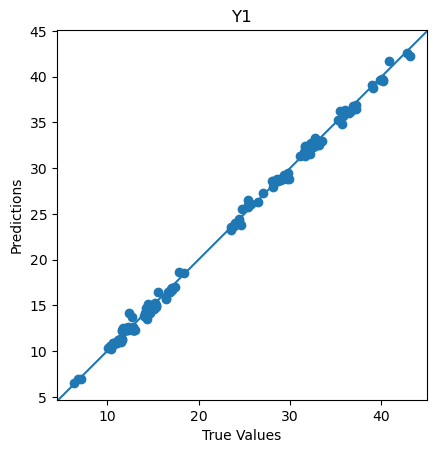

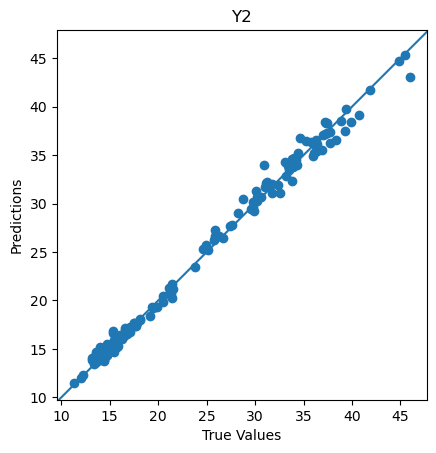

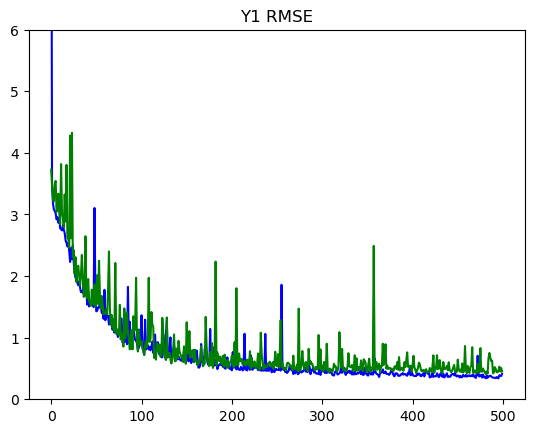

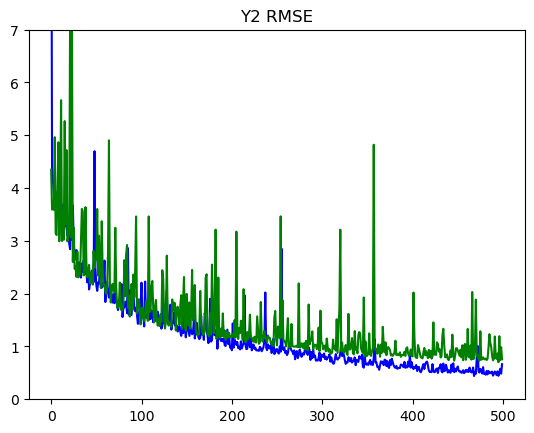

In [12]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)